## Question 1

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import fetch_20newsgroups

categories1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.ibm.pc.hardware' ]
categories2 = [ 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train1 = fetch_20newsgroups(subset='train', categories=categories1, shuffle=True, random_state=42, remove=('headers', 'footers'))
test1 = fetch_20newsgroups(subset='test', categories=categories1, shuffle=True, random_state=42, remove=('headers', 'footers'))
train2 = fetch_20newsgroups(subset='train', categories=categories2, shuffle=True, random_state=42, remove=('headers', 'footers'))
test2 = fetch_20newsgroups(subset='test', categories=categories2, shuffle=True, random_state=42, remove=('headers', 'footers'))


In [49]:
print(train1.target_names)
print(train2.target_names)
print(train1.target)
print(train2.target)

['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.ibm.pc.hardware']
['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
[2 1 2 ... 1 2 2]
[0 3 0 ... 3 1 2]


In [50]:
train1['classNew']= 0
train2['classNew']= 1

In [51]:
X_train1_data = train1.data 
X_train2_data = train2.data
X_train1_data = X_train1_data + X_train2_data
y_train1 = []
for i in range(len(train1.target)):
    y_train1.append(0)
for i in range(len(train2.target)):
    y_train1.append(1)
print(len(y_train1))

4154


In [52]:
count_vect = CountVectorizer(stop_words='english', min_df=3, max_df=0.7)
X_train1_counts = count_vect.fit_transform(X_train1_data)
X_train1_counts.shape

(4154, 16360)

In [53]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_train1_tfidf = tfidf_transformer.fit_transform(X_train1_counts)
print(X_train1_tfidf.shape)

(4154, 16360)


## Question 2 & 3 

In [54]:
from sklearn.cluster import KMeans
from time import time
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix
from plotmat import plot_mat 
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

In [55]:
def return_metrics_score(clusterer,labels,train_embeddings):
    hom = homogeneity_score(labels, clusterer.labels_)
    completeness = completeness_score(labels, clusterer.labels_)
    v_measure = v_measure_score(labels, clusterer.labels_)
    rand_score = adjusted_rand_score(labels, clusterer.labels_)
    mu_info = adjusted_mutual_info_score(labels, clusterer.labels_)
    cm = confusion_matrix(labels, clusterer.labels_)
    return hom,completeness,v_measure,rand_score,mu_info,cm

In [56]:
true_k = 2 

km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=2000,
        n_init=100)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_train1_tfidf)
labels = y_train1
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(max_iter=2000, n_clusters=2, n_init=100)
done in 2.597s



In [57]:
def print_metrics(km,labels,train_embeddings):
    # labels = y_train_full
    print("Homogeneity: %0.3f" % homogeneity_score(labels, km.labels_))
    print("Completeness: %0.3f" % completeness_score(labels, km.labels_))
    print("V-measure: %0.3f" % v_measure_score(labels, km.labels_))
    print("Adjusted Rand-Index: %.3f" % adjusted_rand_score(labels, km.labels_))
    print("Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(labels, km.labels_))
    print("Contingency matrix:")

    cm = confusion_matrix(labels, km.labels_)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

In [58]:
def print_confusion_matrix(cm,labels,km):
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

Homogeneity: 0.535
Completeness: 0.569
V-measure: 0.551
Adjusted Rand-Index: 0.623
Adjusted Mutual Information Score: 0.551
Contingency matrix:


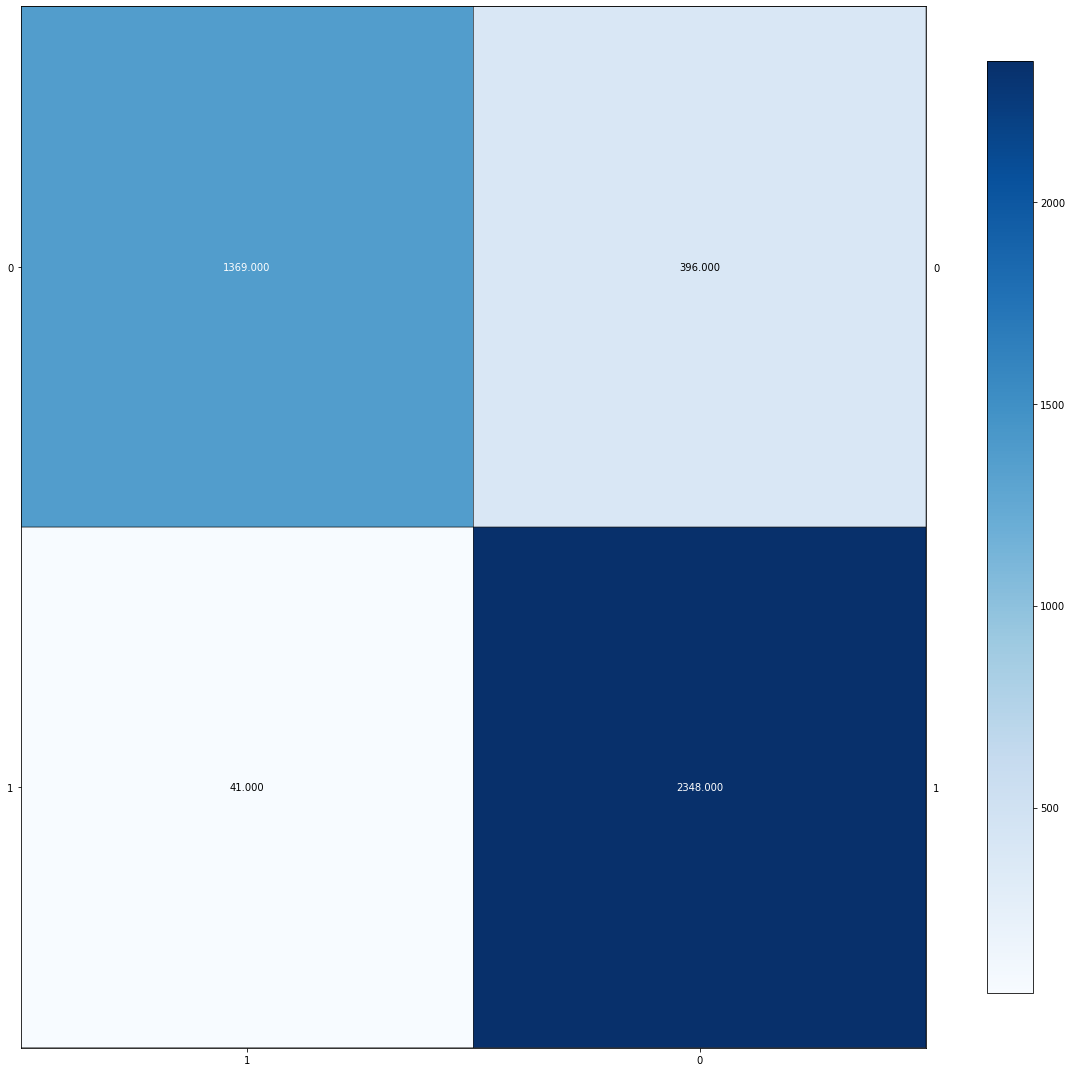

In [59]:
print_metrics(km,labels=labels,train_embeddings=X_train1_tfidf)

## Question 4

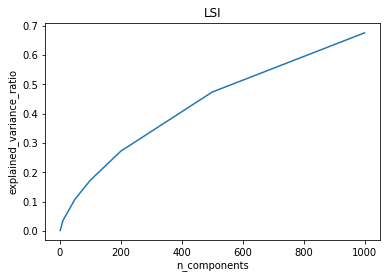

In [60]:
from sklearn.decomposition import TruncatedSVD
k_list = [1,10,50,100,200,500,1000]
explained_ratio = []
for k in k_list:
    svd = TruncatedSVD(n_components=k, n_iter = 20, random_state=42)
    svd.fit(X_train1_tfidf)
    # print(svd.explained_variance_ratio_.sum())
    explained_ratio.append(svd.explained_variance_ratio_.sum())

# plotting the explained variance ratio across number of components
plt.plot(k_list, explained_ratio)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')
plt.title('LSI')
plt.show()

## Question 5

In [81]:
k_list = [1, 2, 3, 5, 10, 20, 50, 100, 300]
homogenity = []
completeness = []
measure = []
adjusted_rand = []
silhouette = []
true_k = 2

for k in k_list:
    svd = TruncatedSVD(n_components=k, n_iter = 20, random_state=42)
    X_train1_svd = svd.fit_transform(X_train1_tfidf)
#     true_k = k
    km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=2000,
        n_init=100)
    km.fit(X_train1_svd)
    labels = y_train1
    homogenity.append(metrics.homogeneity_score(labels, km.labels_))
    completeness.append(metrics.completeness_score(labels, km.labels_))
    measure.append(metrics.v_measure_score(labels, km.labels_))
    adjusted_rand.append(metrics.adjusted_rand_score(labels, km.labels_))
    silhouette.append(metrics.silhouette_score(X_train_svd, km.labels_, sample_size=1000))

   


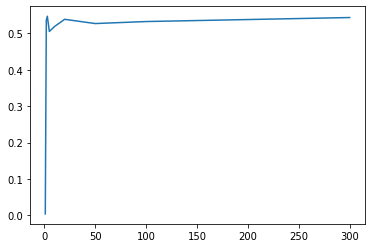

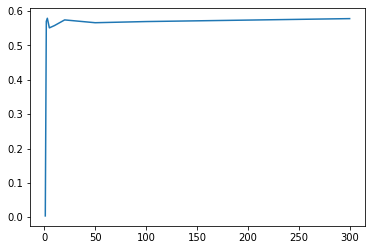

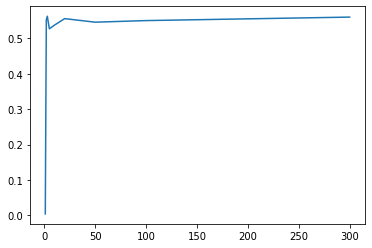

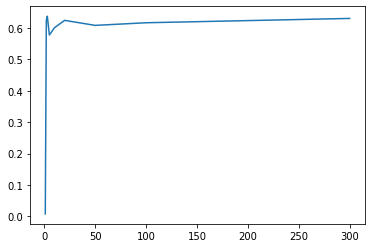

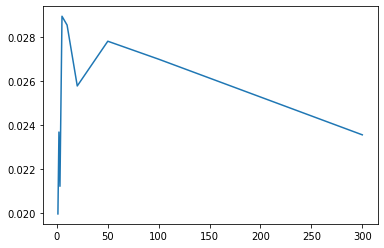

In [82]:
plt.plot(k_list, homogenity)
plt.show()
plt.plot(k_list, completeness)
plt.show()
plt.plot(k_list, measure)
plt.show()
plt.plot(k_list, adjusted_rand)
plt.show()
plt.plot(k_list, silhouette)
plt.show()

In [85]:
from sklearn.decomposition import NMF

k_list = [1, 2, 3, 5, 10, 20, 50, 100, 300]
homogenity = []
completeness = []
measure = []
adjusted_rand = []
silhouette = []
true_k = 2

for k in k_list:
    NMFn = NMF(n_components=k, max_iter = 2000, init='random', random_state=42)
    X_train1_nmf = NMFn.fit_transform(X_train1_tfidf)
#     true_k = k
    km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=2000,
        n_init=100)
    km.fit(X_train1_nmf)
    labels = y_train1
    homogenity.append(metrics.homogeneity_score(labels, km.labels_))
    completeness.append(metrics.completeness_score(labels, km.labels_))
    measure.append(metrics.v_measure_score(labels, km.labels_))
    adjusted_rand.append(metrics.adjusted_rand_score(labels, km.labels_))
    silhouette.append(metrics.silhouette_score(X_train1_tfidf, km.labels_, sample_size=1000))

   

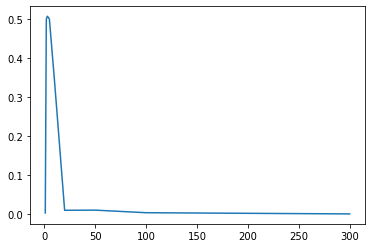

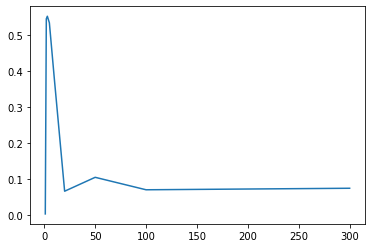

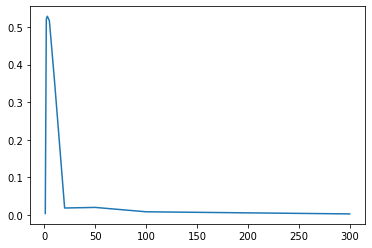

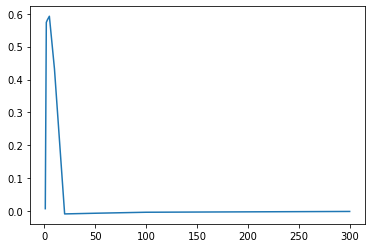

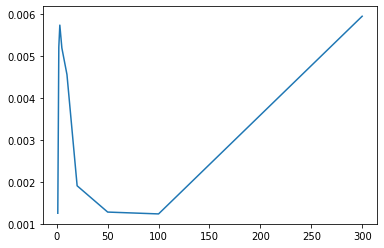

In [86]:
plt.plot(k_list, homogenity)
plt.show()
plt.plot(k_list, completeness)
plt.show()
plt.plot(k_list, measure)
plt.show()
plt.plot(k_list, adjusted_rand)
plt.show()
plt.plot(k_list, silhouette)
plt.show()

## Question 8

In [154]:
# Let's take n_components = 3 for truncatedSVD and perform k-means

true_k = 2
k = 3
svd = TruncatedSVD(n_components=k, n_iter = 20, random_state=42)
X_train1_svd = svd.fit_transform(X_train1_tfidf)
km = KMeans(
    n_clusters=true_k,
    init="k-means++",
    max_iter=2000,
    n_init=100)
km.fit(X_train1_svd)
labels = y_train1


Homogeneity: 0.547
Completeness: 0.579
V-measure: 0.563
Adjusted Rand-Index: 0.638
Adjusted Mutual Information Score: 0.563
Contingency matrix:


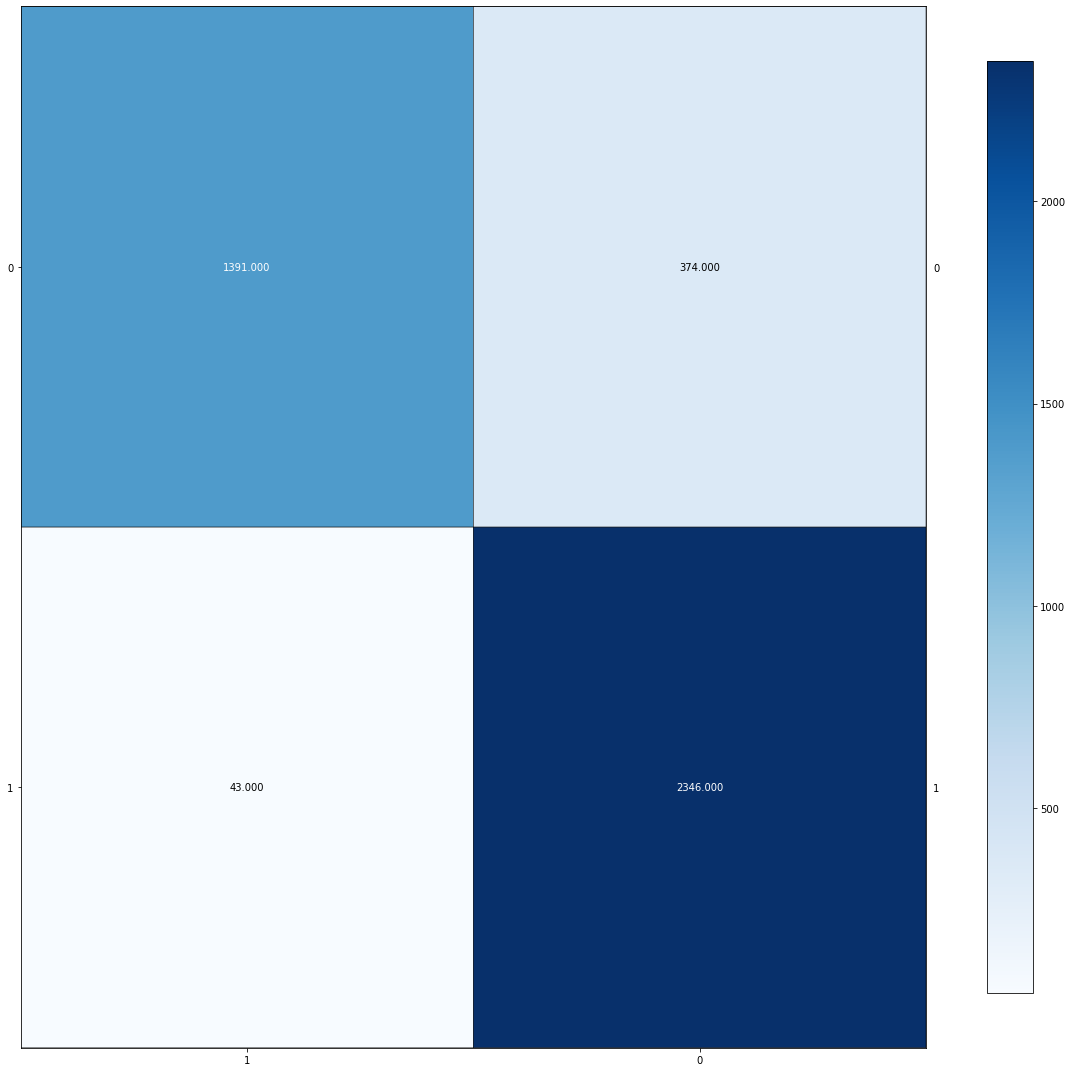

In [155]:
print_metrics(km,labels=labels,train_embeddings=X_train1_svd)

In [156]:
print(km.labels_)

[1 1 1 ... 0 0 1]


In [157]:
# Let's visualize with n_components = 2 
svd = TruncatedSVD(n_components=2, n_iter = 20, random_state=42)
X_train1_svd_visualize = svd.fit_transform(X_train1_svd)

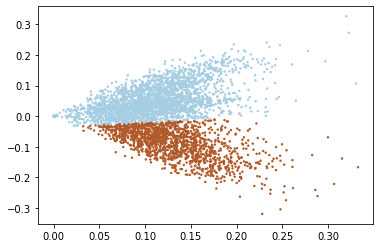

In [163]:
plt.scatter(X_train1_svd_visualize[:,0], X_train1_svd_visualize[:,1], c=km.labels_, s=2, cmap=plt.cm.Paired)
plt.show()

In [165]:
# Let's take n_components = 3 for NMF and perform k-means

true_k = 2
k = 2
NMFn = NMF(n_components=k, max_iter = 2000, init='random', random_state=42)
X_train1_nmf = NMFn.fit_transform(X_train1_tfidf)
km = KMeans(
    n_clusters=true_k,
    init="k-means++",
    max_iter=2000,
    n_init=100)
km.fit(X_train1_nmf)
labels = y_train1

Homogeneity: 0.496
Completeness: 0.542
V-measure: 0.518
Adjusted Rand-Index: 0.569
Adjusted Mutual Information Score: 0.518
Contingency matrix:


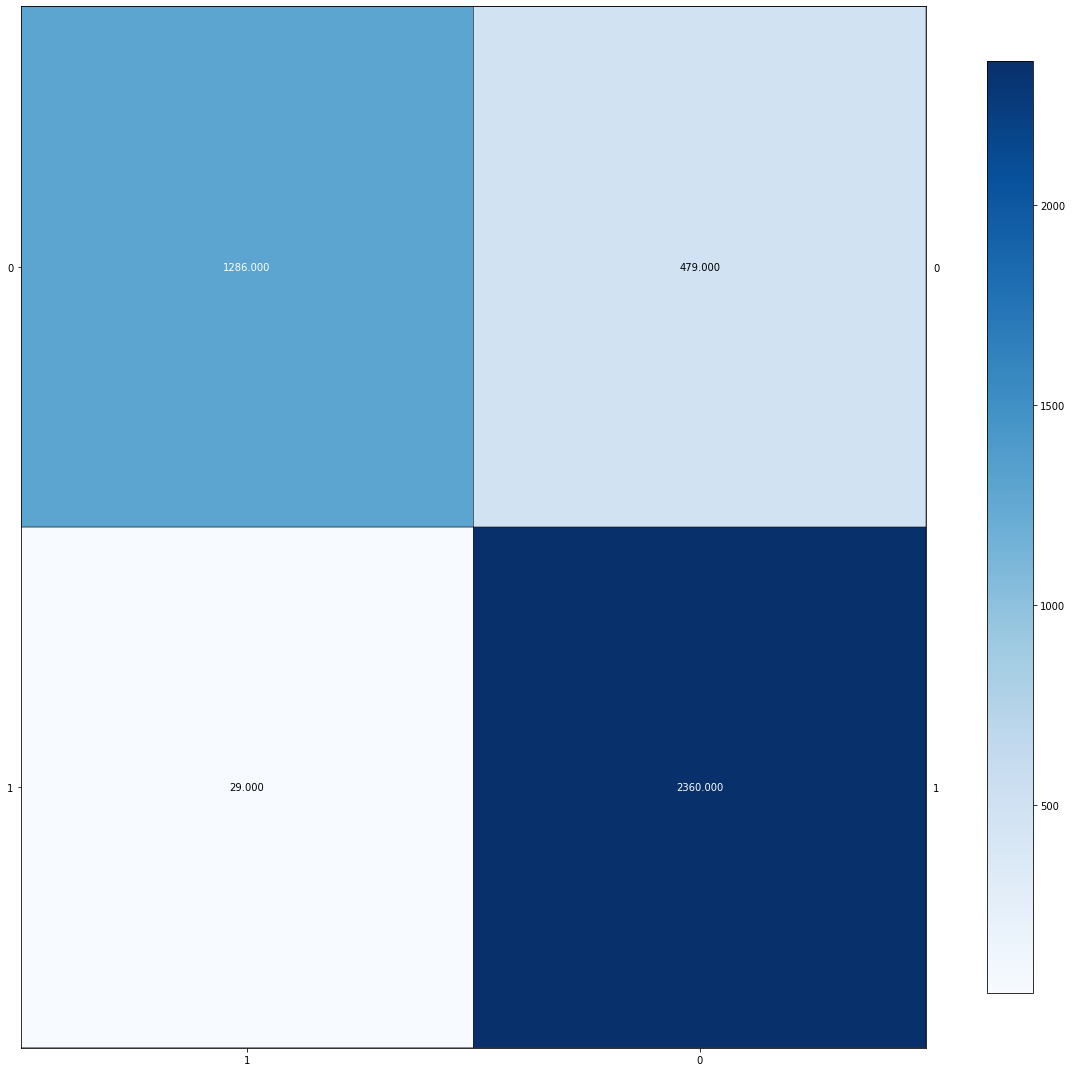

In [166]:
print_metrics(km,labels=labels,train_embeddings=X_train1_nmf)

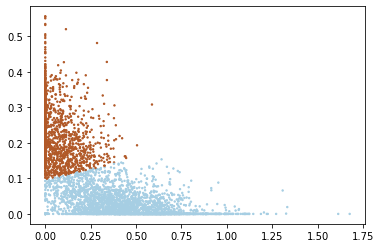

In [167]:
NMFn = NMF(n_components=2, max_iter = 2000, init='random', random_state=42)
X_train1_nmf_visualize = NMFn.fit_transform(X_train1_nmf)
plt.scatter(X_train1_nmf_visualize[:,0], X_train1_nmf_visualize[:,1], c=km.labels_, s=2, cmap=plt.cm.Paired)
plt.show()